In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Load Saved Model
from transformers import BertForSequenceClassification, BertConfig

# Misc.
import warnings
warnings.filterwarnings('ignore')

from transformers import logging
logging.set_verbosity_error()

In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset

In [3]:
df = pd.read_csv('../../data/processed/cleaned_reviews.csv')
df =  df.drop(columns = ["Time"], axis = 1)
df.loc[:,"Sentiment"].replace({'positive':1, 'negative':0}, inplace = True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,Sentiment,Text,review_length,clean_reviews,clean_review_length
0,1,This is a very healthy dog food. Good for thei...,137,healthy dog food good digestion also good smal...,94
1,1,I've been very pleased with the Natural Balanc...,350,pleased natural balance dog food dogs issues d...,218
2,1,"Before I was educated about feline nutrition, ...",733,educated feline nutrition allowed cats become ...,508
3,1,"My holistic vet recommended this, along with a...",493,holistic vet recommended along brands tried ca...,276
4,1,I bought this coffee because its much cheaper ...,413,bought coffee much cheaper ganocafe organic re...,218


# Data Preprocessing

## Tokeniser

In [4]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [5]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


Since BERT works with fixed length sequences, we need to store the length of each review.

In [6]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.clean_reviews:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

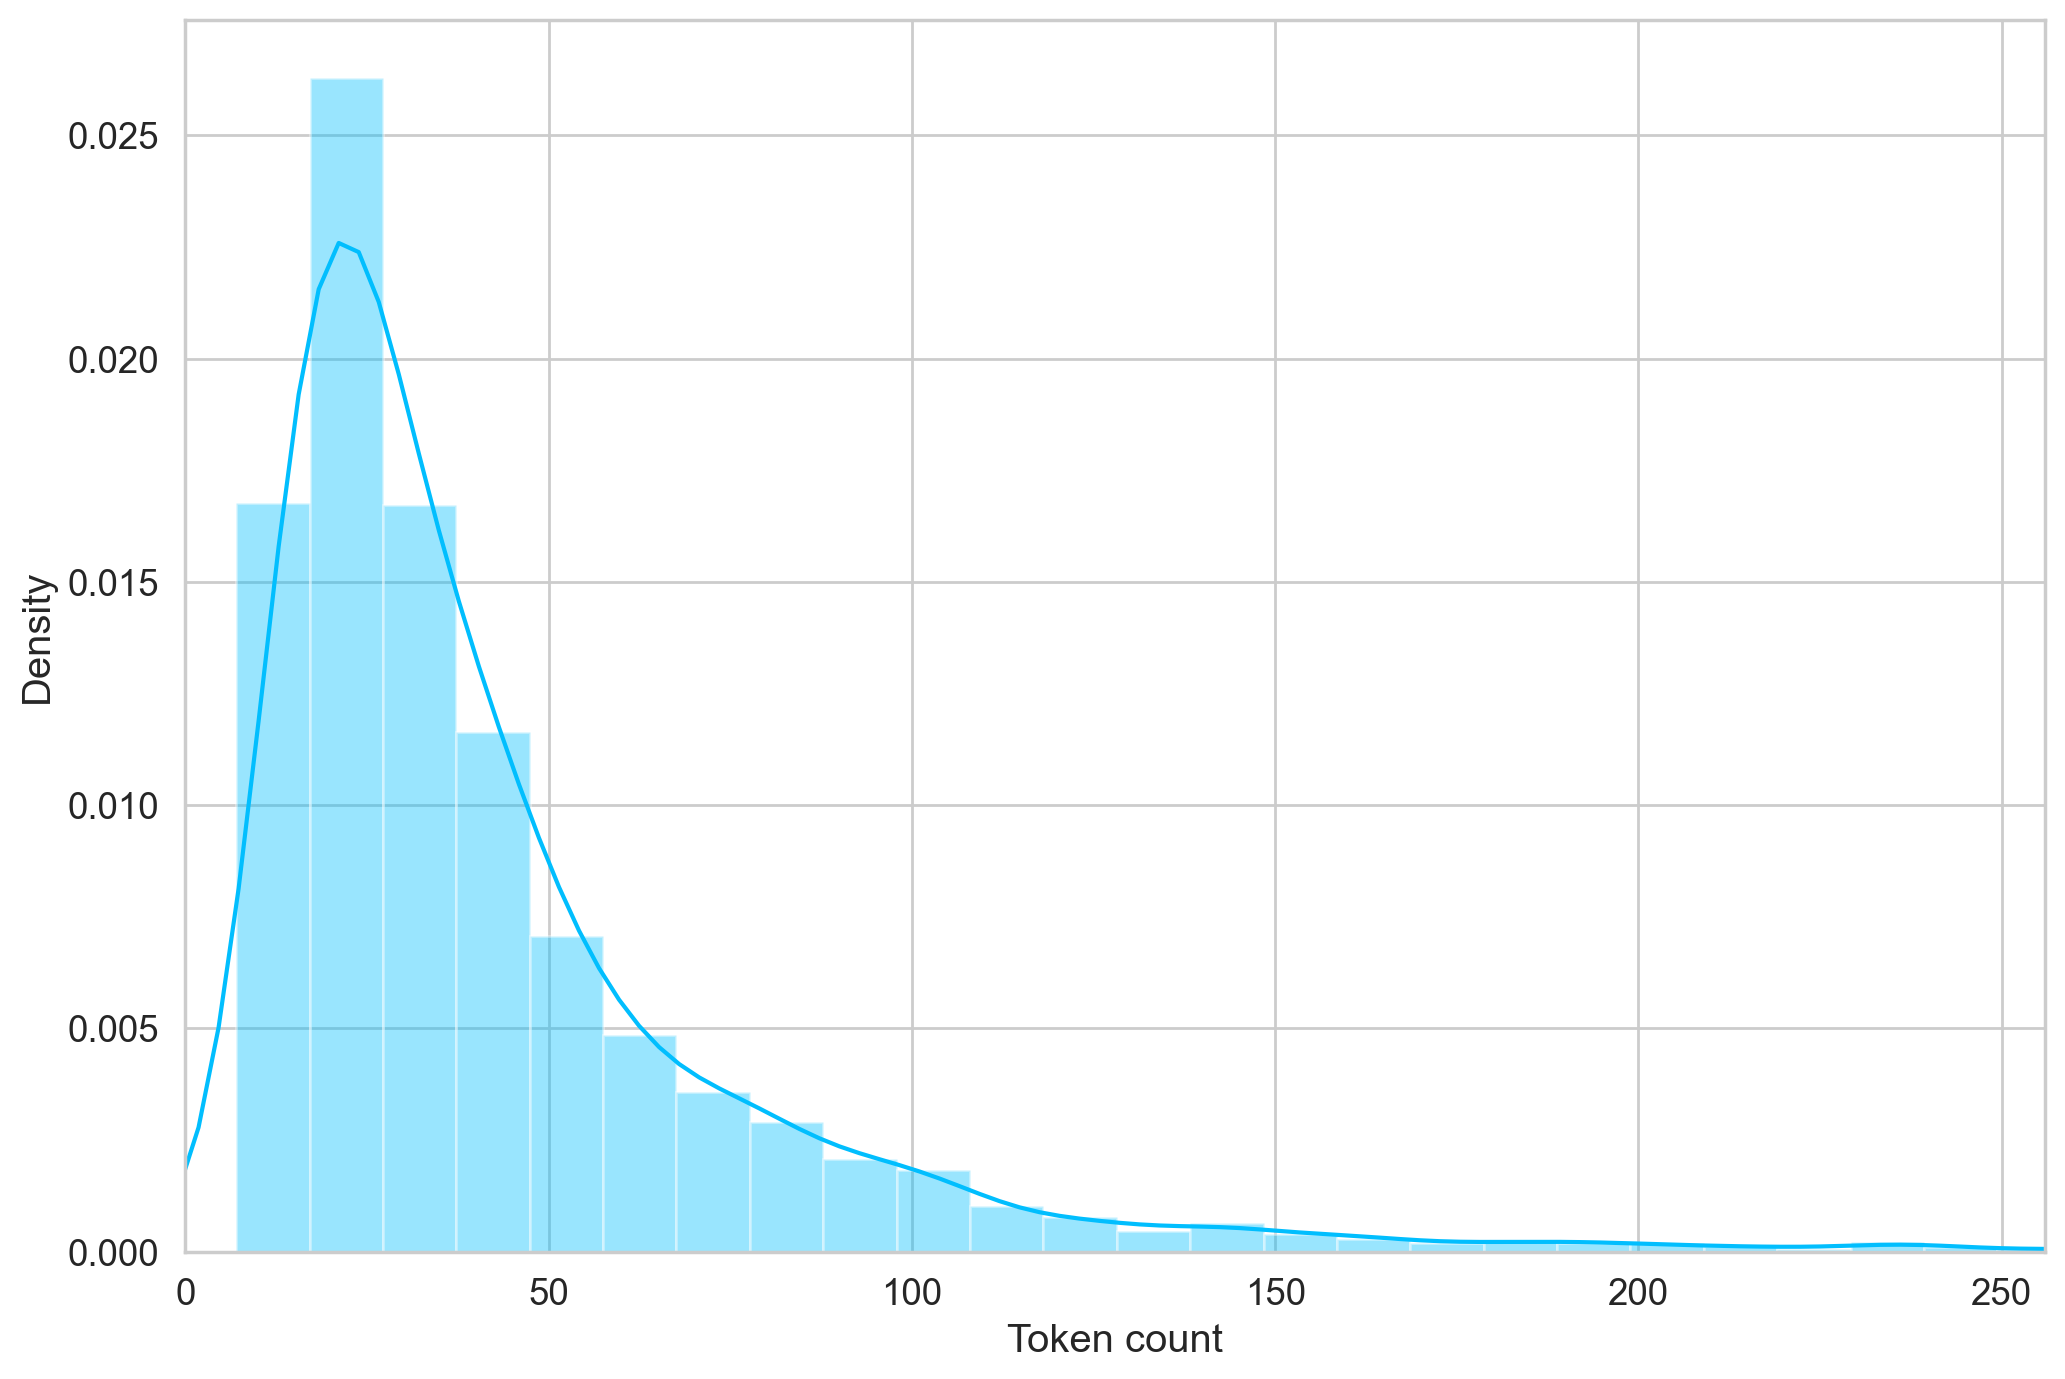

In [7]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [8]:
MAX_LEN = 200

## Torch Dataset Preparation

In [9]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

# Split data into training, test, validation sets

In [10]:
df_train , df_test = train_test_split(df,
                                        test_size = 0.2,
                                        random_state = 4263)

df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=4263)

print(df_train.shape, df_val.shape, df_test.shape)

(4355, 5) (544, 5) (545, 5)


## Data Loader to release data in batches

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.clean_reviews.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [12]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [13]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face

In [14]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [15]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
            , return_dict = False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [16]:
# Instantiate the model and move to classifier
# 1: positive, 0: negative
class_names = ['0','1']
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [17]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


## Training Phase

AdamW optimizer provided by Hugging Face is used. It corrects weight decay. We’ll also use a linear scheduler with no warmup.

In [18]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [19]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            # , return_dict = False
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

## Model Evaluation Function

In [20]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
                # , return_dict = False
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

## Training Loop

In [21]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.4381434396045767 accuracy 0.8142365097588978
Val   loss 0.39875814943190885 accuracy 0.8639705882352942

Epoch 2/10
----------
Train loss 0.27969783444926416 accuracy 0.9026406429391504
Val   loss 0.3867772423717029 accuracy 0.8970588235294118

Epoch 3/10
----------
Train loss 0.21387120544903607 accuracy 0.9437428243398392
Val   loss 0.4276873401694876 accuracy 0.8952205882352942

Epoch 4/10
----------
Train loss 0.16756511036299795 accuracy 0.9605051664753157
Val   loss 0.3771852316910072 accuracy 0.9007352941176471

Epoch 5/10
----------
Train loss 0.11150050695879801 accuracy 0.9763490241102182
Val   loss 0.46616608474184484 accuracy 0.8952205882352942

Epoch 6/10
----------
Train loss 0.090620579728055 accuracy 0.9809414466130884
Val   loss 0.47933089663959383 accuracy 0.9007352941176471

Epoch 7/10
----------
Train loss 0.06429501745791001 accuracy 0.9880597014925373
Val   loss 0.5423722774687443 accuracy 0.8988970588235294

Epoch 8/10
---------

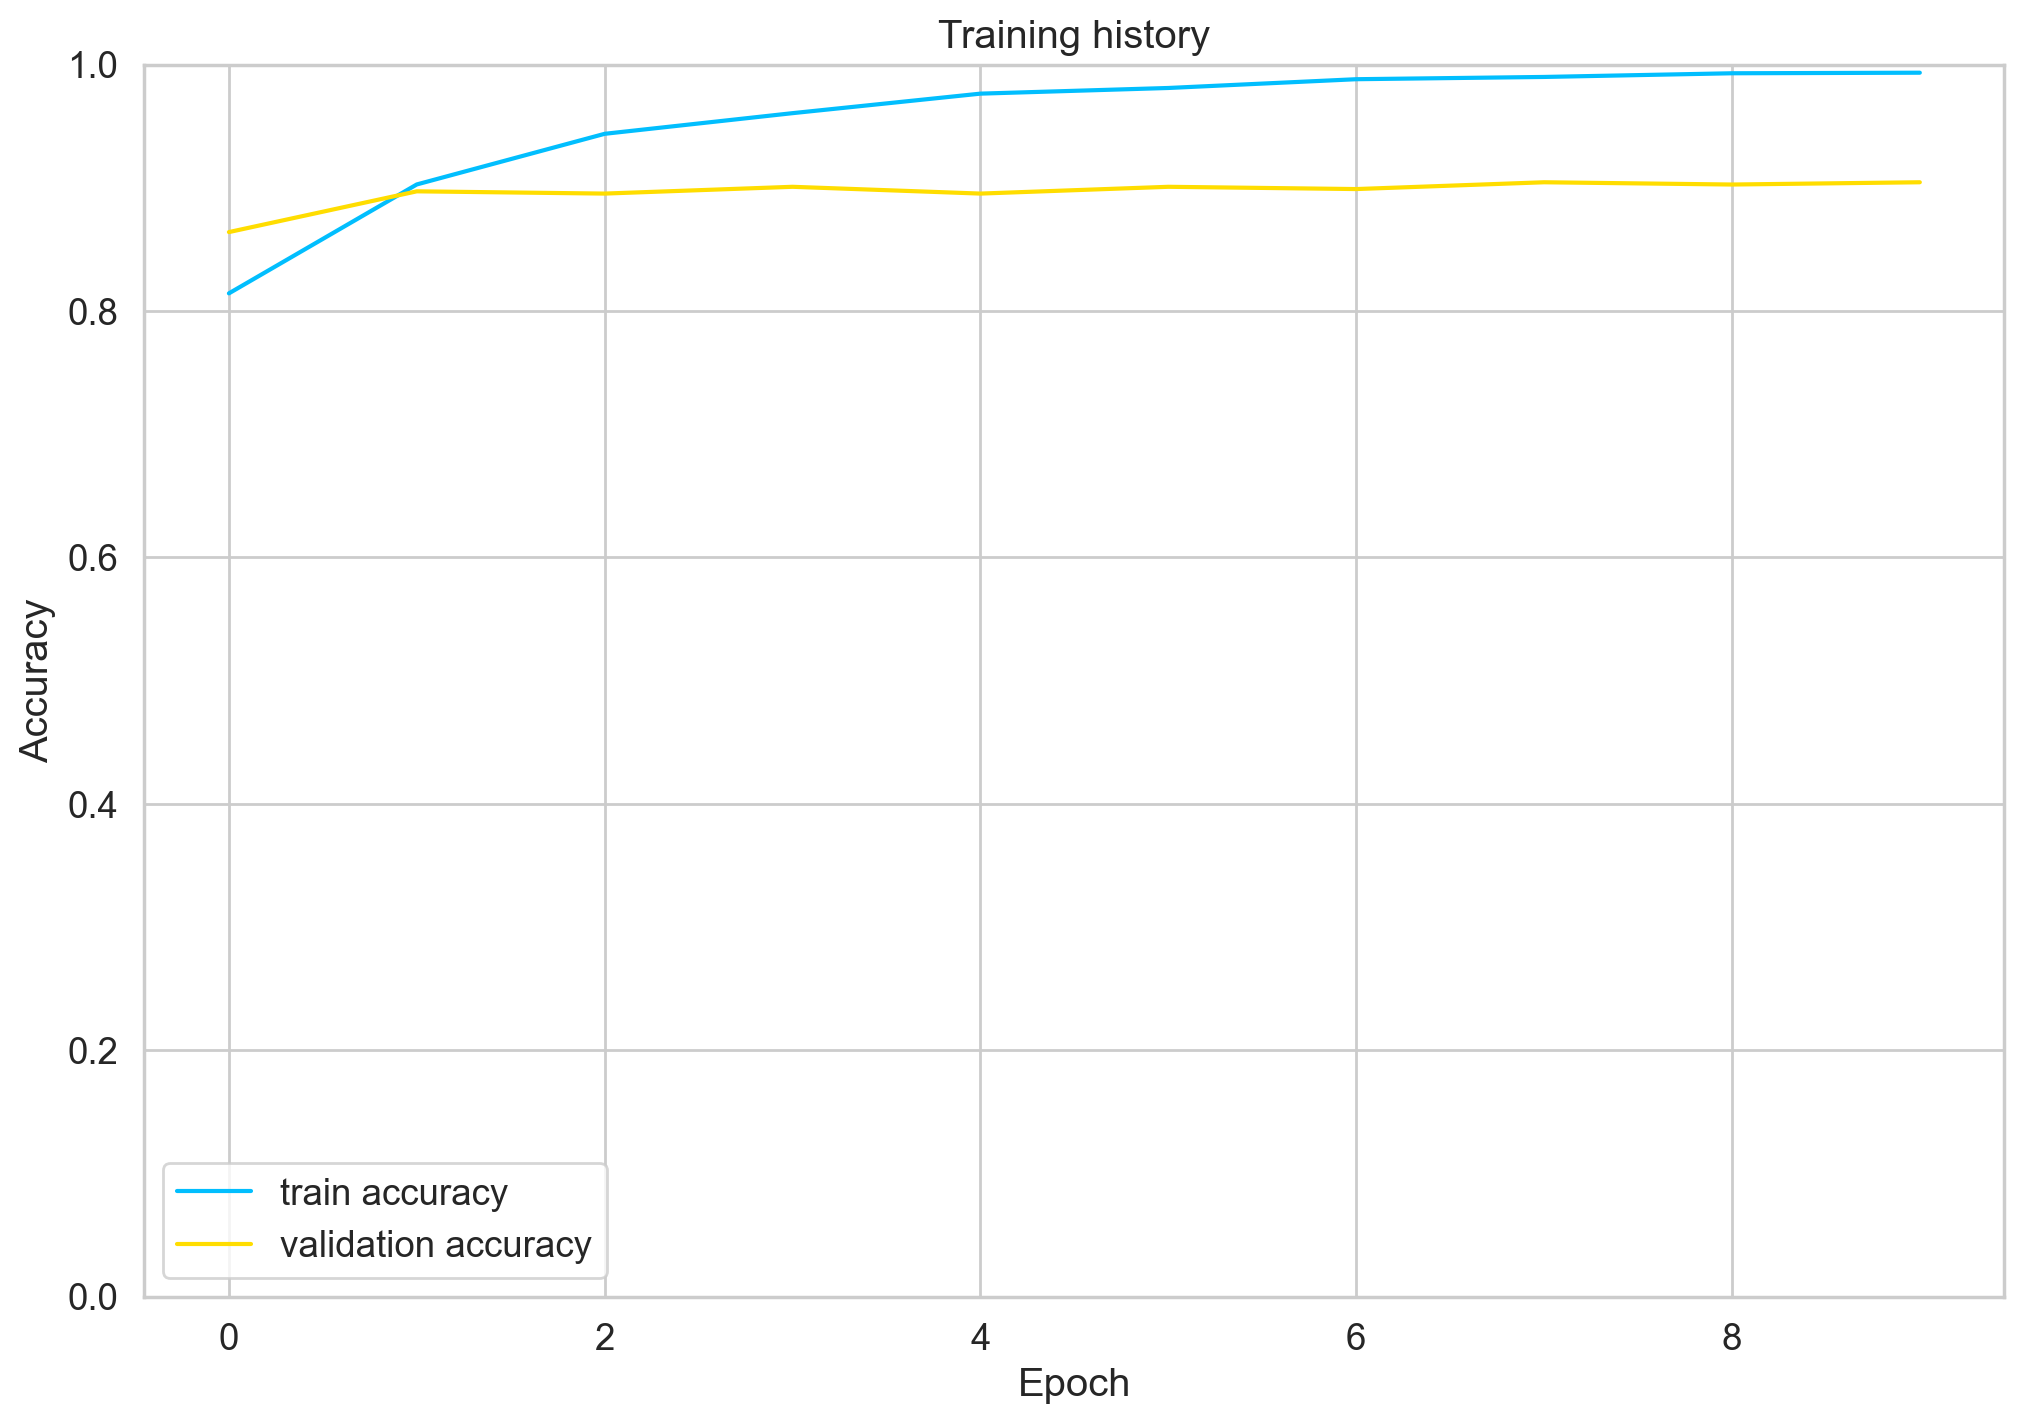

In [22]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Model Evaluation

In [23]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8825688073394495

## Predictions (store text + predicted probabilities)

In [60]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outputs
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [48]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [49]:
class_names = ['0','1']

In [50]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       141
           1       0.91      0.93      0.92       404

    accuracy                           0.88       545
   macro avg       0.85      0.84      0.84       545
weighted avg       0.88      0.88      0.88       545



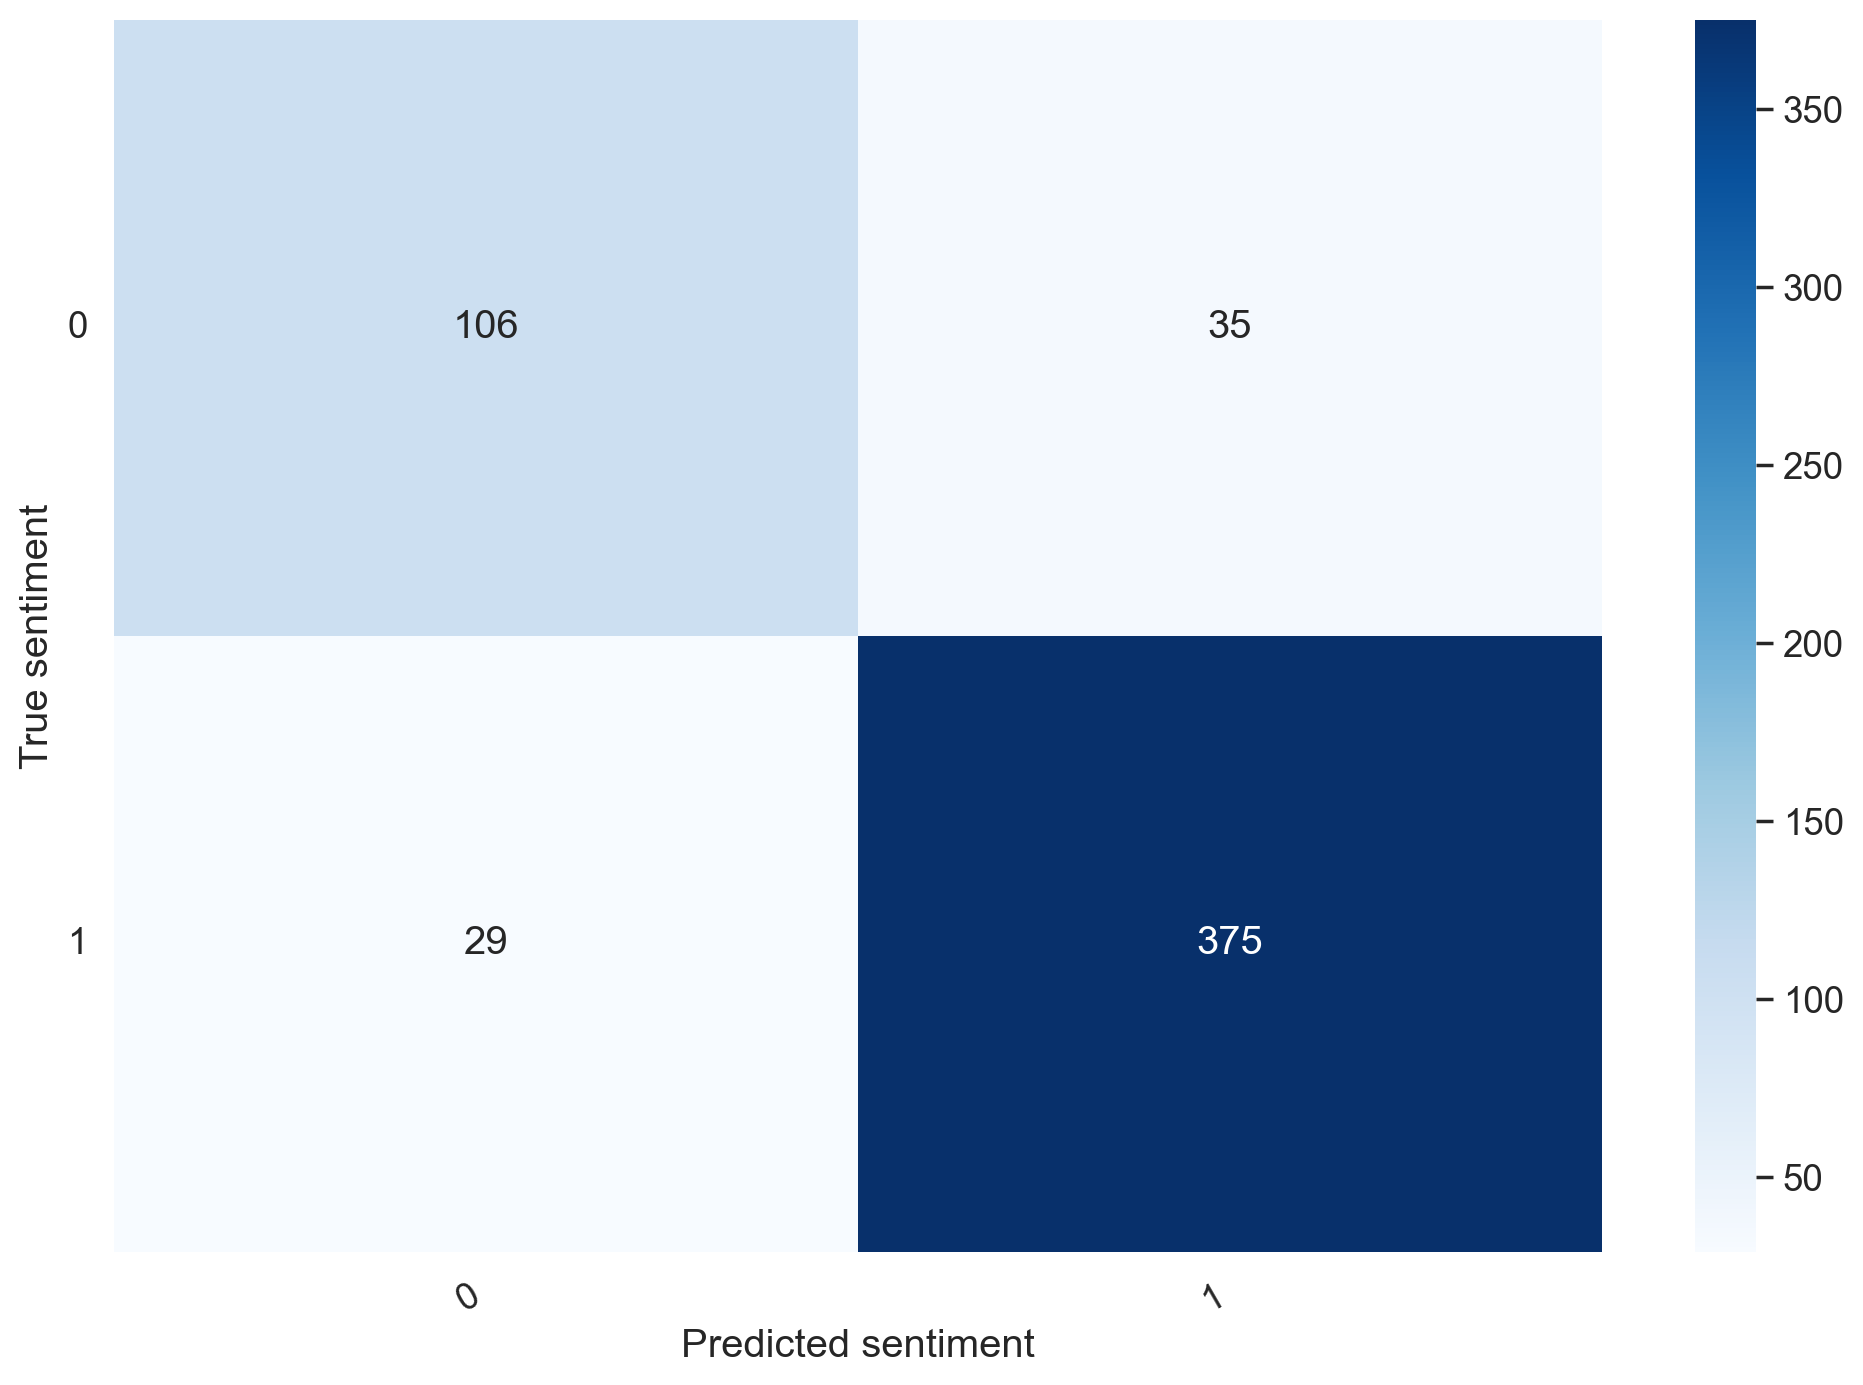

In [51]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Prediction on raw text

In [74]:
review_text = "I do not like the dog food I bought,although it is healthy!"

In [75]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [76]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I do not like the dog food I bought,although it is healthy!
Sentiment  : 1


# Load Saved Model

In [29]:
# Load Saved Model
from transformers import BertForSequenceClassification, BertConfig
MODEL_NAME = "bert-base-cased"
config = BertConfig.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

In [30]:
model.load_state_dict(torch.load("../../data/saved_models/best_model_state.bin"),strict=False)

_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['out.weight', 'out.bias'])

In [31]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

TypeError: max() received an invalid combination of arguments - got (SequenceClassifierOutput, dim=int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)
